In [1]:
import tensorflow as tf
from PIL import Image
from wand import image as wi
import os
import cv2
import matplotlib.pyplot as plt
import datetime
%load_ext tensorboard
import numpy as np
np.set_printoptions(suppress=True)

### Check for data corruption after downloading dataset

In [2]:
rock_path = 'Datasets/rock-paper-scissors-train/rock/'
paper_path = 'Datasets/rock-paper-scissors-train/paper/'
scissors_path = 'Datasets/rock-paper-scissors-train/scissors/'

##### Part-1 : PIL Image corruption check
def image_corruption(dir_cd):
    corrupt_im = []
    for img_file in os.listdir(dir_cd):
        img_path = dir_cd + img_file
        if img_file.endswith('png'):
            try:
               im = Image.open(img_path)
               im.verify()
            except:
                corrupt_im.append(img_file)
                os.remove(img_path)
    return corrupt_im

print("Deleted the corrupted images:")
print(len(image_corruption(rock_path)))
print(len(image_corruption(paper_path)))
print(len(image_corruption(scissors_path)))

Deleted the corrupted images:
0
0
0


In [34]:
##### Part-2 : ImageMagick's Wand Image Corruption check + CV2 Image Corruption check
#####   to handle errors like ==> Corrupt JPEG data: 65 extraneous bytes before marker 0xd9

for img_file in os.listdir(rock_path):
    if img_file.endswith('png'):
        img_path = rock_path + img_file
        wi.Image(filename=img_path)

In [35]:
for img_file in os.listdir(paper_path):
    if img_file.endswith('png'):
        img_path = paper_path + img_file
        wi.Image(filename=img_path)

In [36]:
for img_file in os.listdir(scissors_path):
    if img_file.endswith('png'):
        img_path = scissors_path + img_file
        wi.Image(filename=img_path)

In [37]:
for img_file in os.listdir(rock_path):
    if img_file.endswith('png'):
        img_path = rock_path + img_file
        im = cv2.imread(img_path)

for img_file in os.listdir(paper_path):
    if img_file.endswith('png'):
        img_path = paper_path + img_file
        im = cv2.imread(img_path)

for img_file in os.listdir(scissors_path):
    if img_file.endswith('png'):
        img_path = scissors_path + img_file
        im = cv2.imread(img_path)

### Load dataset

Image size = 300 X 300

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/rock-paper-scissors-train/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size=(150,150),
    shuffle=True,  ###False = Get same results
    seed = 16
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/rock-paper-scissors-validation/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size=(150,150),
    shuffle=True,  ###False = Get same results
    seed = 16
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/rock-paper-scissors-test/',
    image_size=(150,150),
    label_mode=None, #Does not return label
    shuffle=True,
    seed = 16
)
print(train_ds,val_ds,test_ds)

Found 2519 files belonging to 3 classes.
Found 372 files belonging to 3 classes.
Found 33 files belonging to 1 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))> <BatchDataset element_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None)>


2022-10-16 11:14:16.248359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### EDA

In [10]:
for x,y in train_ds:
    pass
print(x.shape,y.shape,type(y))
print(y[0])

(23, 150, 150, 3) (23, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


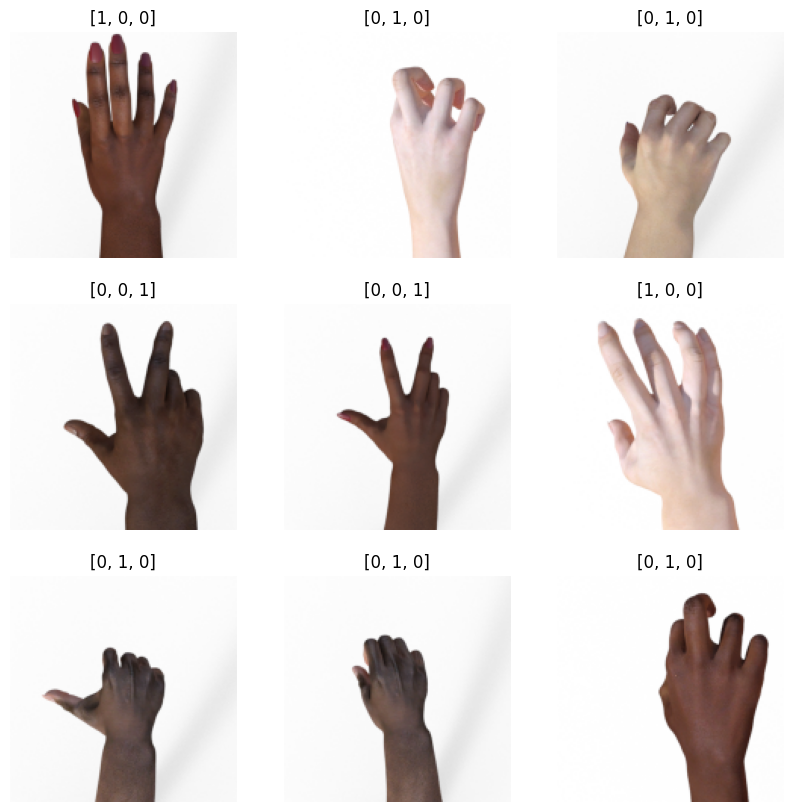

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title([x for x in labels[i].numpy().astype("uint8")])
        plt.axis("off")

### Feature scaling (Normalization) => Preprocessing layer

Data augmentation is inactive at inference time

In [40]:
#!pip install tensorflow-gpu==2.8.3
#https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting

In [41]:
# PPL - Option 1 : Part of model
#rescale_layer = tf.keras.layers.Rescaling(scale=1./255,input_shape=(300,300,3))

# PPL Option 2 : Apply to dataset
train_rescale_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest'), #360 degrees = 100% => 90 deg = 25% (0.25), 45 deg = 0.125
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    #tf.keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(height_factor=0.2,fill_mode='nearest'),
    tf.keras.layers.RandomFlip(mode='horizontal')
])
train_ds = train_ds.map(lambda x,y : (train_rescale_augment(x),y))

val_test_rescale = tf.keras.layers.Rescaling(scale=1./255)
val_ds = val_ds.map(lambda x,y : (val_test_rescale(x),y))
test_ds_scaled = test_ds.map(lambda x : val_test_rescale(x))

### Build MODEL

- (default) steps_per_epoch = No.of training samples//batch_size
- The order of this 3-neuron output would be paper-rock-scissors (e.g. a [0.8 0.2 0.0] output means the model is prediciting 80% probability for paper and 20% probability for rock

In [42]:
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1)
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'Models/C2W4_RockPaperScissors/Checkpoint/rps_model', #_{epoch}',
    monitor = 'val_accuracy',save_best_only = True,save_weights_only = True,verbose=1)
#class AccCheck(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        if logs['accuracy'] >= 0.99:
#            print("Reached 99% accuracy so cancelling training!")
#            self.model.stop_training = True
tb_log_dir = "Models/C2W4_RockPaperScissors/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback_tb = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1, write_graph=True)

# The order of this 3-neuron output would be paper-rock-scissors (e.g. a [0.8 0.2 0.0] output means the model is prediciting 80% probability for paper and 20% probability for rock.
rps_model = tf.keras.models.Sequential([
    #rescale_layer,
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

In [43]:
rps_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [44]:
rps_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [45]:
rps_model_hist = rps_model.fit(train_ds,
                               validation_data = val_ds,
                               epochs = 5,
                               callbacks = [callback_tb,callback_cp])

Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 1.1842 - accuracy: 0.3966
Epoch 1: val_accuracy improved from -inf to 0.64785, saving model to Models/C2W4_RockPaperScissors/Checkpoint/rps_model
79/79 [==============================] - 142s 2s/step - loss: 1.1842 - accuracy: 0.3966 - val_loss: 0.8632 - val_accuracy: 0.6478
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.6014
Epoch 2: val_accuracy did not improve from 0.64785
79/79 [==============================] - 108s 1s/step - loss: 0.8798 - accuracy: 0.6014 - val_loss: 1.2569 - val_accuracy: 0.4113
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7384
Epoch 3: val_accuracy improved from 0.64785 to 0.93548, saving model to Models/C2W4_RockPaperScissors/Checkpoint/rps_model
79/79 [==============================] - 93s 1s/step - loss: 0.6569 - accuracy: 0.7384 - val_loss: 0.3281 - val_accuracy: 0.9355
Epoch 4/5
79/79 [=====================

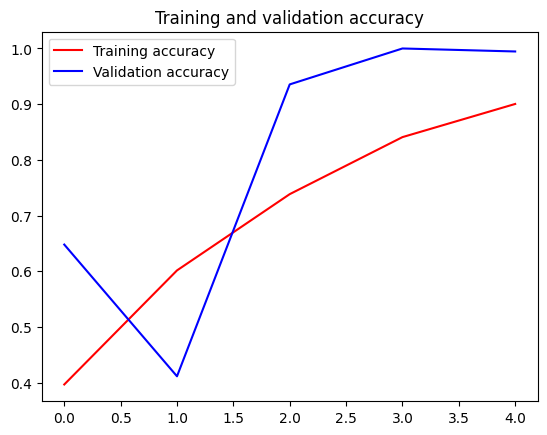

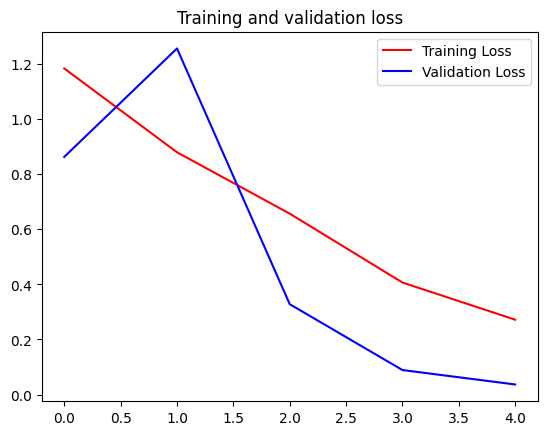

In [46]:
# Plot the model results
acc = rps_model_hist.history['accuracy']
val_acc = rps_model_hist.history['val_accuracy']
loss = rps_model_hist.history['loss']
val_loss = rps_model_hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
#%tensorboard --logdir 'Models/C2W4_RockPaperScissors/logs/'

### Predict


In [48]:
y_pred = rps_model.predict(test_ds_scaled) #new_dc_model.predict(test_ds_scaled)
print(y_pred)

2/2 [==============================] - 0s 14ms/step
[[0.02519077 0.00001872 0.97479045]
 [0.00000002 1.         0.00000004]
 [0.00000001 1.         0.        ]
 [0.99947566 0.00046819 0.00005615]
 [0.00000025 0.9999982  0.00000151]
 [0.9999927  0.         0.00000724]
 [0.00018699 0.         0.999813  ]
 [0.9926668  0.         0.00733323]
 [0.00166842 0.0000057  0.9983259 ]
 [0.00007353 0.0000002  0.9999262 ]
 [0.00003898 0.00000005 0.999961  ]
 [0.000303   0.9988626  0.00083439]
 [0.75788    0.00000745 0.24211265]
 [0.8929188  0.00345973 0.1036214 ]
 [0.49428946 0.00000615 0.5057044 ]
 [0.00027553 0.         0.99972445]
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.01106672 0.00000106 0.98893225]
 [0.00000112 0.9999987  0.0000002 ]
 [0.99998116 0.         0.00001889]
 [0.00000073 0.9999957  0.00000358]
 [0.02565663 0.00583967 0.9685037 ]
 [0.9999949  0.         0.00000509]
 [0.9998456  0.00000001 0.00015432]
 [0.9999517  0.         0.00004825]
 [0.31739172